# Enunciado del ejercicio

Queremos agarrar el conjunto de datos de los pingüinos del otro día y probar a realizar unos modelos de aprendizaje automático de regresión y otro de clasificación. Para ello, vamos a:

Tomar como X el df sin el peso y SIN la isla. 

Para regresión, tomaremos como y el peso. 

Para clasificación, tomaremos como y la isla. 

En cualquier caso, codearemos las variables no numéricas de X e Y (label enconder y acabamos antes) y normalizaremos todas las variables de X. 

Comprobaremos el error cometido y lo compararemos con otro modelo del mismo tipo. 

Si queréis probar el no supervisado, usando kmeans, ¿qué 3 grupos se formaría si solo atendemos a la longitud y anchura del pico? 

# Esquema General

```python
from AlgúnSitio import Modelo_Chulo
modelo = Modelo_Chulo(hiperparámetros)
modelo.fit(X_train, y_train) # aquí es donde tarda
y_pred = modelo.predict(X_test)
revisar_errores(y_test,y_pred)
```

# Importamos librerías y leemos datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
penguins.shape

(344, 7)

In [5]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [6]:
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [7]:
penguins.dropna(inplace=True)
penguins.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [8]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
X.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,Adelie,39.1,18.7,181.0,Male
1,Adelie,39.5,17.4,186.0,Female
2,Adelie,40.3,18.0,195.0,Female
4,Adelie,36.7,19.3,193.0,Female
5,Adelie,39.3,20.6,190.0,Male


In [9]:
X.shape

(333, 5)

# Regresión: `y=penguins["body_mass_g"]`

## Preparación de datos

Queremos que nuestra variable objetivo, y, sea el peso de los pingüinos, y vamos a predecirlo con las variables de X: Bill length, bill depth, flipper length, sex y species

In [9]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y = penguins["body_mass_g"]

## ElasticNet

In [10]:
#Librerías
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
alpha = 0.1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = 0.1 #Parámetro que mide el tradeoff entre el peso l1 y el l2

#Instanciamos el modelo
model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 42)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas] #Esto es un poco redundante en este caso, pero es que en otros ejemplos, como en KNN, sí tenemos que añadir 
# alguna otra columna, como clasificacion[columnas + ["otra_columna"]], o porque la copia proviene no de X sino de otro dataframe con más columnas

#Codeamos las variables no numéricas
encoder = LabelEncoder()
regresion["species"] = encoder.fit_transform(regresion["species"])
regresion["sex"] = encoder.fit_transform(regresion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
regresion[columnas] = scaler.fit_transform(regresion[columnas])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_ElasticNet = mse(y_test, y_pred) 

# donde mse_ElasticNet = np.sum((y_test-model.predict(X_test))**2)/1000

In [11]:
mse_ElasticNet

102805.38696264444

## Stochastic Gradient Descent

In [12]:
#Librerías
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
penalty = 'elasticnet' #Elegimos entre penalización 'l2', 'l1' o 'elasticnet'
alpha = .1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = .1 #Parámetro que mide el tradeoff entre el peso l1 y el l2

#Instanciamos el modelo
model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 42)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
regresion["species"] = encoder.fit_transform(regresion["species"])
regresion["sex"] = encoder.fit_transform(regresion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
regresion[columnas] = scaler.fit_transform(regresion[columnas])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SGDRegressor = mse(y_test,model.predict(X_test))
print(mse_SGDRegressor)

103267.10209636834


## Support Vector Regression

In [13]:
#Librerías
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
C = 1 #Parámetro regularizador
kernel = 'rbf' #Núcleo transformador
#Instanciamos el modelo
model = svm.SVR(C = C, kernel = kernel)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
regresion["species"] = encoder.fit_transform(regresion["species"])
regresion["sex"] = encoder.fit_transform(regresion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
regresion[columnas] = scaler.fit_transform(regresion[columnas])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SVR = mse(y_test,model.predict(X_test))
print(mse_SVR)

585767.5413556347


## Random Forest

In [14]:
#Librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
n_estimators = 200 #Estimadores del modelo
criterion = 'squared_error' #Forma de calcular el error
max_depth = None #Límite de profundidad de los árboles
min_samples_split = 2 #Criterio de parada de profundidad
verbose = 1 #Información devuelta por el método

#Instanciamos el modelo
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
regresion["species"] = encoder.fit_transform(regresion["species"])
regresion["sex"] = encoder.fit_transform(regresion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
regresion[columnas] = scaler.fit_transform(regresion[columnas])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_RF = mse(y_test,model.predict(X_test))
print(mse_RF)

81345.2278125


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


## Boosting: Gradient Descent

In [15]:
#Librerías
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
regresion["species"] = encoder.fit_transform(regresion["species"])
regresion["sex"] = encoder.fit_transform(regresion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
regresion[columnas] = scaler.fit_transform(regresion[columnas])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Convertimos los datos a formato DMatrix
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

#Instanciamos el modelo, entrenamos y elaboramos predicciones
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test,model.predict(test_data))
print(mse_XGB)

79672.00410452187


## Comparativa de Modelos

Text(0.5, 0, 'Modelo')

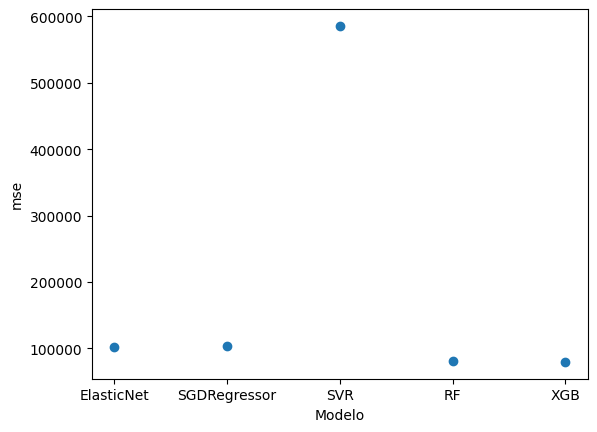

In [16]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_SVR, mse_RF, mse_XGB]
plt.scatter(['ElasticNet', 'SGDRegressor', 'SVR', 'RF', 'XGB'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo')

El peor modelo sería el Support Vector Regression (SVR) y el mejor sería Boosting Gradient Descent (XGB)

# Clasificación: `y=penguins["island"]`

Queremos que nuestra variable objetivo, y, sea la isla de los pingüinos, y vamos a predecirlo con las variables de X: Bill length, bill depth, flipper length, sex y species

In [33]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y=penguins["island"]

## Modelo Logístico

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Instanciamos el modelo
model = LogisticRegression(C=0.1, max_iter=1000)

#Entrnamos en los datos
model.fit(X_train, y_train)

#Predecimos
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.85      0.82      0.83        49
       Dream       0.63      0.89      0.74        37
   Torgersen       1.00      0.07      0.13        14

    accuracy                           0.74       100
   macro avg       0.83      0.59      0.57       100
weighted avg       0.79      0.74      0.70       100



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Instanciamos el modelo
model = LogisticRegression(max_iter=100)

#Entrnamos en los datos
model.fit(X_train, y_train)

#Predecimos
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.82      0.84      0.83        49
       Dream       0.73      0.86      0.79        37
   Torgersen       0.33      0.14      0.20        14

    accuracy                           0.75       100
   macro avg       0.63      0.61      0.61       100
weighted avg       0.72      0.75      0.73       100



## K-Nearest Neighbours

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Parámetros
weights = 'distance'
p = 2
n_neighbours = 5

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.79      0.86      0.82        49
       Dream       0.82      0.84      0.83        37
   Torgersen       0.33      0.21      0.26        14

    accuracy                           0.76       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.74      0.76      0.75       100



In [21]:
valores_de_k = list(range(1,31))
grid_de_k = dict(n_neighbors = valores_de_k)

from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(weights = weights, p = p)
grid = GridSearchCV(knn, grid_de_k,cv =10, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 1}


## Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo
NBmodelo = GaussianNB()

NBmodelo.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.79      0.86      0.82        49
       Dream       0.82      0.84      0.83        37
   Torgersen       0.33      0.21      0.26        14

    accuracy                           0.76       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.74      0.76      0.75       100



## Support Vector Machine

Versión Simple

In [23]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

SVM = svm.SVC()
SVM.fit(X_train, y_train)
y_preds = SVM.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

      Biscoe       1.00      0.82      0.90        49
       Dream       0.62      0.97      0.76        37
   Torgersen       0.00      0.00      0.00        14

    accuracy                           0.76       100
   macro avg       0.54      0.60      0.55       100
weighted avg       0.72      0.76      0.72       100



Version con dibujos (más dificil)

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=0.1),
        svm.LinearSVC(C= 10, max_iter=30000),
        svm.SVC(kernel='poly', degree = 3, C=C),
        svm.SVC(kernel='poly', degree = 2, C=C),
        svm.SVC(kernel='rbf', gamma=0.7, C=C),
        svm.SVC(kernel='rbf', gamma=5, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel (C=0.1)',
        'SVC with linear kernel (C=10)',
        'SVC with polynomial kernel (degree = 3)',
        'SVC with polynomial kernel (degree = 2)',
        'SVC with RBF kernel (gamma = 0.7)',
        'SVC with RBF kernel (gamma = 5)')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2,3,figsize=(20,12))
plt.subplots_adjust(wspace=.1, hspace=.1)

clasificacion = np.array(clasificacion)  # Convert regresion to a NumPy array
X0, X1 = clasificacion[:, 0], clasificacion[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Decission Tree

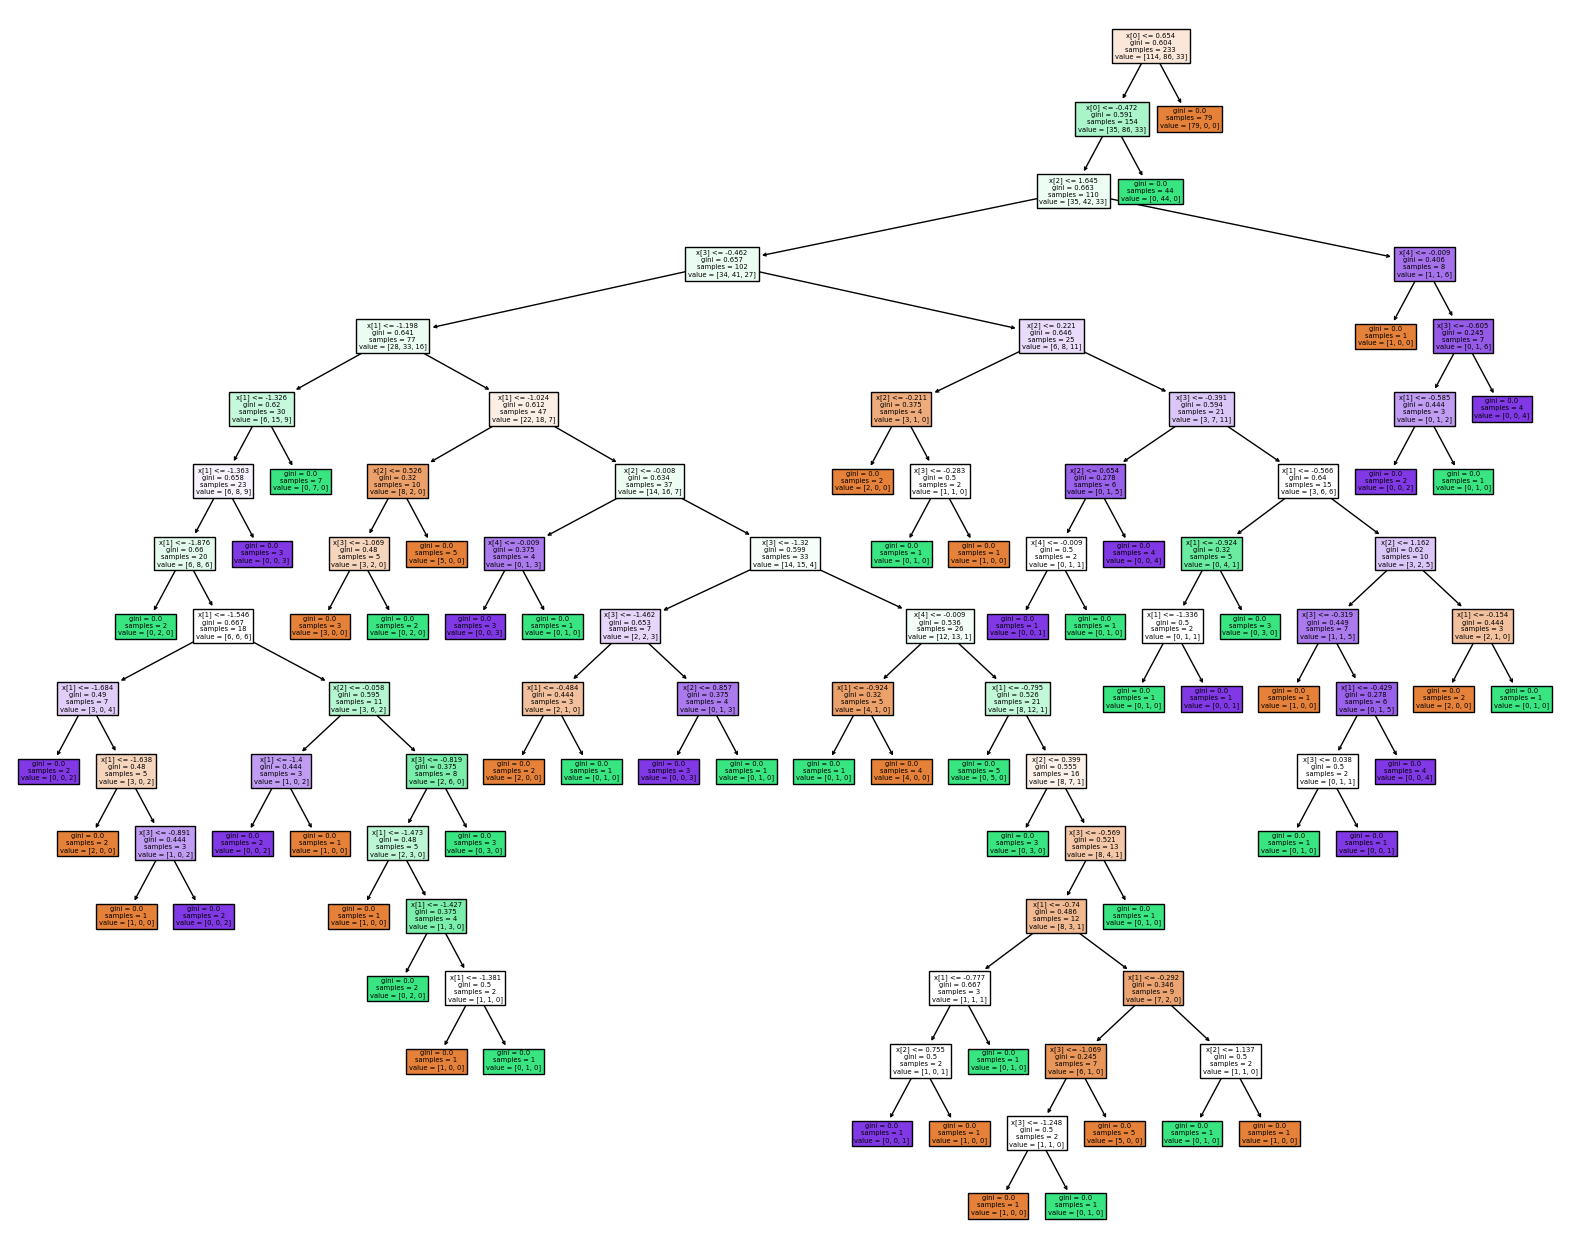

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

plt.figure(figsize = (20,16))
clf = DecisionTreeClassifier().fit(X_train, y_train)
plot_tree(clf, filled=True)
plt.show()

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

      Biscoe       0.77      0.84      0.80        49
       Dream       0.78      0.76      0.77        37
   Torgersen       0.18      0.14      0.16        14

    accuracy                           0.71       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.69      0.71      0.70       100



In [27]:
isla = np.array([[0,39.2,18.6,181.2,0]])

In [28]:
RFC.predict(isla)

C:\Users\juanv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Dream'], dtype=object)

In [29]:
penguins["island"].unique() #está prediciendo que es una de estas 3

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

## Extra: *Receiver Operating Characteristic*

Esto no es un modelo, se tiene que añadir al modelo que quieras y listo

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)

# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()

Por ejemplo:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Parámetros
weights = 'distance'
p = 2
n_neighbours = 5

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas
encoder = LabelEncoder()
clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)

# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()

#### Atención! El roc va a seguir sin funcionar, porque y_pred solo puede tomar 2 valores, ya que el roc mide aciertos vs fallos. Sin embargo, el código está bien escrito, es simplemente un problema del conjunto de datos, que no tiene ninguna variable "binaria" (hombre-mujer, true-false, maduro-inmaduro, 0-1, aprobado-suspenso....)

# Aprendizaje No Supervisado

## Kmeans (pendiente)

In [10]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y=penguins["island"]

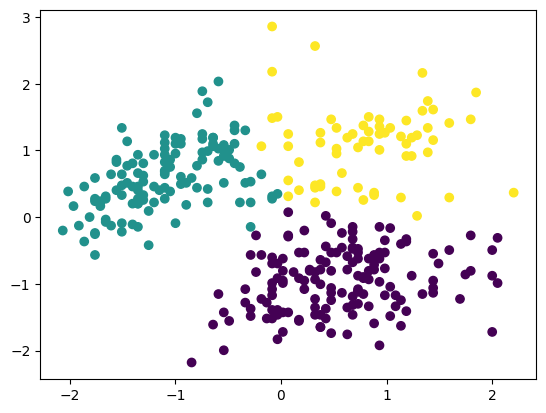

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Fijamos una semilla
np.random.seed(42)

#Variables dependientes
clasificacion = X.copy()
columnas = ["bill_length_mm", "bill_depth_mm"]
clasificacion = clasificacion[columnas]

#Codeamos las variables no numéricas (no hay)
# encoder = LabelEncoder()
# clasificacion["species"] = encoder.fit_transform(clasificacion["species"])
# clasificacion["sex"] = encoder.fit_transform(clasificacion["sex"])

#Normalizamos las variables numéricas
scaler = StandardScaler()
clasificacion[columnas] = scaler.fit_transform(clasificacion[columnas])

#Dividimos los datos en datos de entrenamiento y datos de validación (No hay que hacer esto en un NO supervisado)
# X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

clusters = len(np.unique(y))
km = KMeans(n_clusters=clusters, random_state=42)
km.fit(clasificacion)
y_pred = km.predict(clasificacion)

# Graficamos
plt.scatter(clasificacion["bill_depth_mm"], clasificacion["bill_length_mm"], c=y_pred, cmap='viridis')